# Bow data processing to extract cutting efficiency of a diamond wire

This package is used to calculate the cutting efficiency from bow data measured in-situ during diamond wire cutting of a silicon brick into wafers. The calculation consists of the following successive steps:
<br>
   - Conversion of the instrumental time of the bow measurement into the percentage of cut duration 
   - Bow data smoothing to get rid of the fluctuations related to the backward-and-forward wire motion 
   - Bow data downsampling to keep a reasonable number of measurements (about 150 points) 
   - Vertical force computation from the smoothed and downsamples bow data using equation 3 (publication ref)
   - Cutting efficiency computation from the computed vertical force using equation 4 (publication ref)
    
### Inputs
The processing requires at least:
<br>
- The following parameters:
          
  - cut_name: Reference of the experimental cut
  - time_to_contact (s): Experimental time to contact the silicon brick with wire web 
  - cut_effective_duration (min): Effective duration of the cut
  - sensors_nbr: Number of sensors used for the bow measurements
  - wire_guides_gap (mm): Distance of the wire guides to the brick
  - brick_width (mm): Width of the silicon brick to be cut
  - wire_tension (N): Tension applied to the wire
  - table_speed (mm/min): Speed of the brick downward motion 
  - wire_speed (m/s): Average absolute value of the wire speed
  <br>
- A data frame data with the following fields:
     
  - 'Time (s)'   : Instrumental time of measurement 
  - 'Bow # (mm)' : Bow measurement at sensor number #
 <br> 
 
 However the bow measurements may be in a specific format that should be converted to provide the above inputs
 
### Outputs
'Results_' + cut_name + '.xlsx', EXCEL file composed of 3 sheets:
<br>
 - Sheet "Bow": Smoothed and downsampled bow values (mm) vs percentage of cut duration
 - Sheet "Force": Computed vertical force (N) vs percentage of cut duration
 - Sheet "Kappa": Computed cutting efficiency (${\rm{10}}$${^{ - 7}}$ ${\rm{m.N}}$${^{ - 1}}$) vs percentage of cut duration
<br>     
     

# Specification of paths

In [1]:
# Main for this cell
# Version 2021/02/22
'''
Specification of paths depending of the OS and user
'''
# Standard library imports
import os
from pathlib import Path

# Specific to Jupyter
%matplotlib inline  

# Path of 'site-packages' where useful packages are stored on MAC-OS
mac_packages = "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages" 

# Root directory for all files 
root = Path("C:/Users/franc/OneDrive/Bureau/confocal")
data_folder = Path("fichiers/publi INES") 
if not os.path.isdir(root) : 
    root = Path('/Users/amal/Documents/0- AC sur Mac/Coustier & al_extrait') 
    data_folder = "Fichiers EXEL corrigés"

# Path identification for data access and results saving
my_path= root / Path(data_folder)

print('Paths defined')

Paths defined


# Batch plot of bow 
## For a set of cuts that may be limited to one cut
The cell below uses, from the BKU_Utils package, the following local functions:
- Bow_Kappa_files
- Param_extract
- Data_extract
<br>
<br>

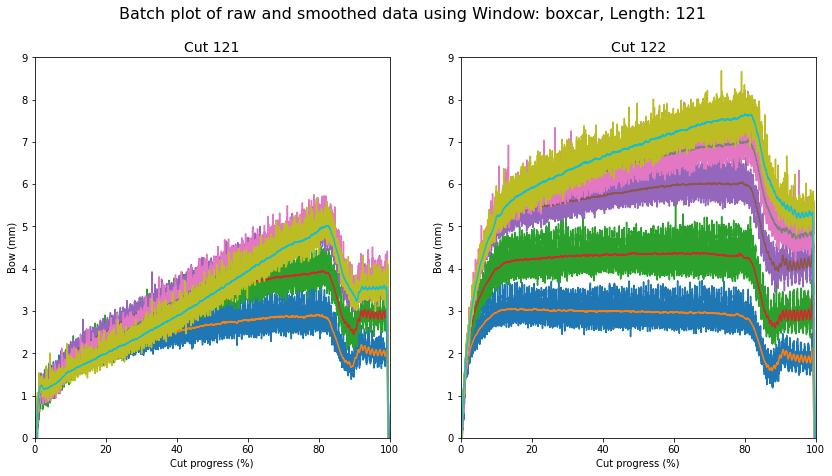

In [59]:
# Version 2021.02.24
# Batch plot of raw and smoothed data of the measured bow for a set of cuts 
# The data from the common sensors used by the set of cuts are plotted on the same graph for each cut
# on the whole cut duration
# Set of cuts may be limited to 1 cut

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal 

# Local imports 
try: # standard storage path of 'site-packages' on WIN
    import BKU_Utils as bku
except: # Add storage path of 'site-packages' on MAC-OS
    import sys
    sys.path.append(mac_packages)
    import BKU_Utils as bku
    
# Global variables
bku.LONG = 121      # Length of the moving window for bow data smoothing; must be odd; default value = 121
bku.WIN = 'boxcar'  # Kind of moving window; default value = 'boxcar';
                    # in ['boxcar', 'triang', 'hamming', 'blackman', 'bartlett', 'parzen', 'bohman']
                    
# Set of smoothing and downsampling parameters
norme = sum(signal.get_window(bku.WIN, bku.LONG))

# Data set identification
cuts = ["121", "122"] 

# Set the plot range for the bow data in mm
bow_min, bow_max = 0, 9

# Set figure parameters for batch plot
fig = plt.figure(figsize=(7*len(cuts),7))   # Plot area 
gs = gridspec.GridSpec(1, len(cuts))
fig.suptitle(f'Batch plot of raw and smoothed data using Window: {bku.WIN}, Length: {bku.LONG}\n', \
             fontsize = 16)

# Set useful sheet names
sheet_params = "Params"
sheet_data = "Raw data"
        
# Set list of file names and parameters for each cut
bow_file_list, kappa_file_list, dparam_list, sensors_nbr_list = [], [], [], []
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = bku.Bow_Kappa_files(cut_name, my_path)
    bow_file_list.append(bow_file_cut)
    kappa_file_list.append(kappa_file_cut)
    
    dparam_cut = bku.Param_extract(bow_file_cut, sheet_params)
    sensors_nbr_cut = np.array(dparam_cut['Value'])[4]
    dparam_list.append(dparam_cut)
    sensors_nbr_list.append(sensors_nbr_cut)

# Identify the number of common sensors to the set of cuts
sensors_nbr = min(sensors_nbr_list)    

# Batch plot of the cuts
i_cut = 0 # initialization on the cut index
i_ax = 0  # initialization on the ax index
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = str(bow_file_list[i_cut]), str(kappa_file_list[i_cut])
    dparam_cut = dparam_list[i_cut]
    dbow = bku.Data_extract(bow_file_cut, sheet_data, sensors_nbr)
    
    # Get useful parameters for time conversion to cut progress ratio
    time_to_contact = np.array(dparam_cut['Value'])[2]
    cut_effective_duration = np.array(dparam_cut['Value'])[3]
    
    # Conversion  of time to cut progress ratio 
    per_cent_coupe = np.array(dbow['Time (s)'])
    time_init = per_cent_coupe[0]
    per_cent_coupe = 100 * (per_cent_coupe - time_init - time_to_contact) / (60*cut_effective_duration)

    # Smooth, downsample and plot the data using a moving window of length long and of type win
    bow_name = [x for x in dbow.columns if 'Bow' in x]
    ax=fig.add_subplot(gs[0,i_ax])
    for bow in bow_name:
        dbow_filter = dbow[bow].rolling(bku.LONG,center=True, win_type=bku.WIN, axis=0).sum()/norme
        ax.plot(per_cent_coupe,dbow[bow])
        ax.plot(per_cent_coupe,dbow_filter)
    
    ax.set_xlim(0, 100)   # set limits of x axis
    ax.set_ylim(bow_min, bow_max)   # set limits of y axis
    ax.set_xlabel('Cut progress (%)')
    ax.set_ylabel('Bow (mm)')
    ax.set_title(f'Cut {cut_name}', fontsize = 14)
    
    i_ax=i_ax+1
    i_cut=i_cut+1
                       
plt.show()


# Batch plot of a smoothed time derivative of bow 
## For a set of cuts that may be limited to one cut
The cell below uses, from the BKU_Utils package, the following local functions:
- Bow_Kappa_files
- Param_extract
- Data_extract
<br>
<br>

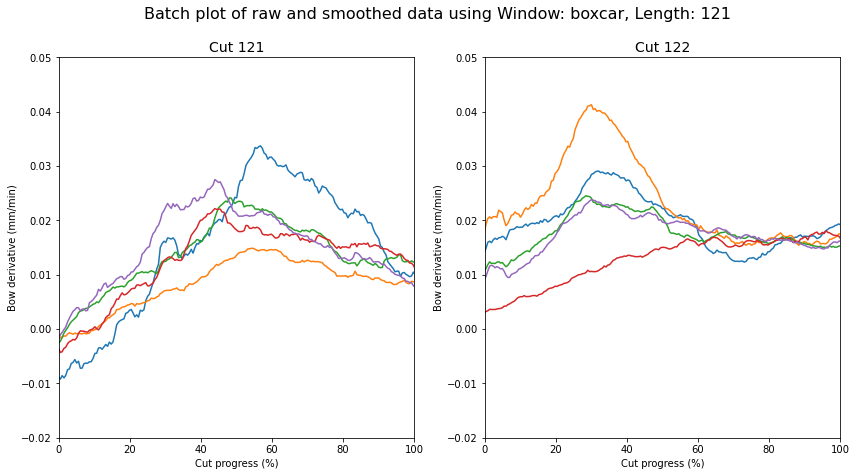

In [81]:
# Version 2021.02.24
# Batch plot of the time derivative of smoothed data of the measured bow for a set of cuts 
# The data from the common sensors used by the set of cuts are plotted on the same graph for each cut
# on the whole cut duration
# Set of cuts may be limited to 1 cut

# 3rd party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal 

# Local imports 
try: # standard storage path of 'site-packages' on WIN
    import BKU_Utils as bku
except: # Add storage path of 'site-packages' on MAC-OS
    import sys
    sys.path.append(mac_packages)
    import BKU_Utils as bku
    
# Global variables
bku.LONG = 121      # Length of the moving window for bow data smoothing; must be odd; default value = 121
bku.WIN = 'boxcar'  # Kind of moving window; default value = 'boxcar';
                    # in ['boxcar', 'triang', 'hamming', 'blackman', 'bartlett', 'parzen', 'bohman']
                    
# Set of smoothing and downsampling parameters of bow
norme = sum(signal.get_window(bku.WIN, bku.LONG))

# Set of smoothing and downsampling parameters of bow
der_long = 10
der_win = 'boxcar' 
der_norme = sum(signal.get_window(der_win, der_long))

# Data set identification
cuts = ["121","122"] 

# Set the plot range for the bow data in mm
der_bow_min, der_bow_max = -0.02, 0.05

# Set the plot range for the cut progress in
der_cut_min, der_cut_max = 0, 100

# Set figure parameters for batch plot
fig = plt.figure(figsize=(7*len(cuts),7))   # Plot area 
gs = gridspec.GridSpec(1, len(cuts))
fig.suptitle(f'Batch plot of raw and smoothed data using Window: {bku.WIN}, Length: {bku.LONG}\n', \
             fontsize = 16)

# Set useful sheet names
sheet_params = "Params"
sheet_data = "Raw data"
        
# Set list of file names and parameters for each cut
bow_file_list, kappa_file_list, dparam_list, sensors_nbr_list = [], [], [], []
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = bku.Bow_Kappa_files(cut_name, my_path)
    bow_file_list.append(bow_file_cut)
    kappa_file_list.append(kappa_file_cut)
    
    dparam_cut = bku.Param_extract(bow_file_cut, sheet_params)
    sensors_nbr_cut = np.array(dparam_cut['Value'])[4]
    dparam_list.append(dparam_cut)
    sensors_nbr_list.append(sensors_nbr_cut)

# Identify the number of common sensors to the set of cuts
sensors_nbr = min(sensors_nbr_list)    

# Batch plot of the cuts
i_cut = 0 # initialization on the cut index
i_ax = 0  # initialization on the ax index
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = str(bow_file_list[i_cut]), str(kappa_file_list[i_cut])
    dparam_cut = dparam_list[i_cut]
    dbow = bku.Data_extract(bow_file_cut, sheet_data, sensors_nbr)
    
    # Get useful parameters for time conversion to cut progress ratio
    time_to_contact = np.array(dparam_cut['Value'])[2]
    cut_effective_duration = np.array(dparam_cut['Value'])[3]
    
    # Conversion  of time to cut progress ratio 
    per_cent_coupe = np.array(dbow['Time (s)'])
    time_init = per_cent_coupe[0]
    per_cent_coupe = 100 * (per_cent_coupe - time_init - time_to_contact) / (60*cut_effective_duration)
    time = per_cent_coupe *(60*cut_effective_duration)/100
    
    # Smooth, downsample and plot the data using a moving window 
    bow_name = [x for x in dbow.columns if 'Bow' in x]
    ax=fig.add_subplot(gs[0,i_ax])
    for bow in bow_name:
        dbow_filter = dbow[bow].rolling(bku.LONG,center=True, win_type=bku.WIN, axis=0).sum()/norme
        bow_smooth = np.array(dbow_filter)
        der_bow = (np.diff(bow_smooth)/np.diff(time))
        dder_bow = pd.DataFrame (der_bow,columns=['Column_Name'])
        dder_dbow_filter = dder_bow.rolling(der_long,center=True, win_type=der_win, axis=0).sum()/der_norme
        ax.plot(time[0:-1],dder_dbow_filter )
    
    ax.set_xlim(der_cut_min, der_cut_max)   # set limits of x axis
    ax.set_ylim(der_bow_min, der_bow_max)   # set limits of y axis
    ax.set_xlabel('Cut progress (%)')
    ax.set_ylabel('Bow derivative (mm/min)')
    ax.set_title(f'Cut {cut_name}', fontsize = 14)
    
    i_ax=i_ax+1
    i_cut=i_cut+1
                       
plt.show()


# Batch 3D plot of cutting efficiency 
## For a set of cuts that may be limited to one cut
The cell below uses, from the BKU_Utils package, the following local functions:
- Bow_Kappa_files
- Param_extract
- Data_extract
- bow2kappa
- Kappa_3Dplot_values
- Kappa_Wireframe
<br>
<br>

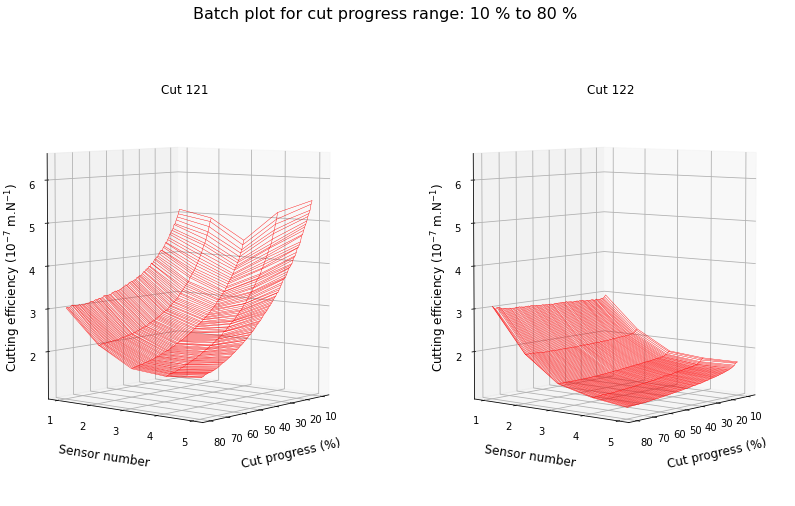

In [80]:
# Version 2021.02.22
# Batch 3D plot of cutting efficiency data calculated from the measured bow for a set of cuts 
# The data from the common sensors used by the set of cuts are plotted on a 3D graph for each cut
# on the specified cut duration
# Set of cuts may be limited to 1 cut

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Local imports 
try: # standard storage path of 'site-packages' on WIN
    import BKU_Utils as bku
except: # Add storage path of 'site-packages' on MAC-OS
    import sys
    sys.path.append(mac_packages)
    import BKU_Utils as bku
    
# Global variables
bku.LONG = 121      # Length of the moving window for bow data smoothing; must be odd; default value = 121
bku.WIN = 'boxcar'  # Kind of moving window; default value = 'boxcar';
                    # in ['boxcar', 'triang', 'hamming', 'blackman', 'bartlett', 'parzen', 'bohman']

# Data set identification
cuts = ["121","122"] 

# Set the plot range for the cutting progress in % of cut duration
cut_min, cut_max = 10, 80

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set figure parameters
fig = plt.figure(figsize=(7*len(cuts),8))   # Plot area 
gs = gridspec.GridSpec(1, len(cuts))
fig.suptitle(f'Batch plot for cut progress range: {cut_min} % to {cut_max} %', fontsize = 16)

# Set useful sheet names
sheet_params = "Params"
sheet_data = "Raw data"
sheet_kappa = "Kappa"

# Set file names, parameters and sensors number for batch plot
bow_file_list, kappa_file_list, dparam_list, sensors_nbr_list = [], [], [], []
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = bku.Bow_Kappa_files(cut_name, my_path)
    bow_file_list.append(bow_file_cut)
    kappa_file_list.append(kappa_file_cut)
    
    dparam_cut = bku.Param_extract(bow_file_cut, sheet_params)
    sensors_nbr_cut = np.array(dparam_cut['Value'])[4]
    dparam_list.append(dparam_cut)
    sensors_nbr_list.append(sensors_nbr_cut)

# Identify the number of common sensors to the set of cuts
sensors_nbr = min(sensors_nbr_list)    

# Batch wireframe 3D plot of the cuts
i_cut = 0 # initialization on the cut index
i_ax = 0  # initialization on the ax index
for cut_name in cuts:
    
    bow_file_cut, kappa_file_cut = str(bow_file_list[i_cut]), str(kappa_file_list[i_cut])
    dparam_cut = dparam_list[i_cut]
    
    try:         
        dkappa_cut = bku.Data_extract(kappa_file_cut, sheet_kappa, sensors_nbr)
    except: 
        dbow_cut = bku.Data_extract(bow_file_cut, sheet_data, sensors_nbr)
        _= bku.bow2kappa(dbow_cut, dparam_cut, kappa_file_cut)
        dkappa_cut = bku.Data_extract(kappa_file_cut, sheet_kappa, sensors_nbr)
    
    x,y,z,cut_progress_nb = bku.Kappa_3Dplot_values(dkappa_cut, cut_min, cut_max,\
                                                    eff_min, eff_max, sensors_nbr)
    
    # Plotting the wireframe 3D plot
    ax=fig.add_subplot(gs[0,i_ax], projection='3d') # Frame for 3D plot 
    bku.Kappa_Wireframe(x, y, z, eff_min, eff_max, cut_name, sensors_nbr, cut_progress_nb, ax)
    
    i_ax=i_ax+1
    i_cut=i_cut+1
    
plt.show()

#  Statistical analysis for a specified cut-progress slice of a single cut data 
## Data from one sensor or all of them may be used   
The cell below uses, from the BKU_Utils package, the following local functions:
- Kappa_data
- Kappa_flatten
- Kappa_hist
- Kappa_bbox
<br>
<br>

In [ ]:
# Main for histogram plot and boxplot of data of a single sensor or of data from all sensors
# Version 2021.02.22

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt 

# Local imports 
try: # standard storage path of 'site-packages' on WIN
    import BKU_Utils as bku
except: # Add storage path of 'site-packages' on MAC-OS
    import sys
    sys.path.append(mac_packages)
    import BKU_Utils as bku

# Global variables
bku.BINS = 25   # Bins for histogram plot

# Data set identification
cut_name = "121"

# Set useful sheet names
sheet_params = "Params"
sheet_kappa = "Kappa"

# Set file names and parameters of kappa data
bow_file, kappa_file= bku.Bow_Kappa_files(cut_name, my_path)
dparam = bku.Param_extract(bow_file, sheet_params)
sensors_nbr = np.array(dparam['Value'])[4]
sensor_init = np.array(dparam['Value'])[5]

# Set de sensor from which the data will be analysed
sensor = 1      # =< sensors_nbr; number of the sensor of which data will be kept for the analysis
                # If sensor = 0, data of all sensors will be kept for the analysis 

# Set the plot range for the cutting progress in % of cut duration
cut_min, cut_max = 10, 80

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set the plot range for the cut progress in % of cut duration
interv = 20  # Range length of cut-progress slice (%)
num_max = int((cut_max - cut_min) / interv)
num = 1      # Index of cut-progress slice, to be controled to avoid that cut_max_interv > cut_max

if num <= num_max: # Check index suitability of cut-progress slice 
    
    # set bounds of cut-progress slice
    cut_min_interv = cut_min + interv * (num - 1)
    cut_max_interv = cut_min_interv + interv
    if cut_max_interv > cut_max:
        cut_max_interv = cut_max

    # Set the dictionary of the cutting efficiency data to be plot using Kappa_data function
    dkappa_flatten = bku.Kappa_flatten(kappa_file, cut_min_interv, cut_max_interv, \
                                   sensors_nbr, sensor_init, sensor, sheet_kappa)

    # Figure settings
    fig = plt.figure(figsize=(12,6))

    # Subplot settings for histogram plot
    plt.subplot(1,2,1)
    plt.suptitle(f'Cut: {cut_name}          Sensor index: {sensor}',fontsize=14)
                 
    # Plot the histogram of cutting efficency data using Kappa_hist function
    plt.title(f'Cut progress range: {cut_min_interv} % to {cut_max_interv} %')
    bku.Kappa_hist(dkappa_flatten, eff_min, eff_max)    
    
    # Subplot settings for boxplot plot
    plt.subplot(1,2,2)

    # Plot the BoxPlot of cutting efficency data using Kappa_bbox function
    # Statistics computation
    k_mean = "{:5.2f}".format(np.mean(dkappa_flatten)) 
    k_max = "{:5.2f}".format(np.max(dkappa_flatten)) 
    k_min = "{:5.2f}".format(np.min(dkappa_flatten))
    plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
    bku.Kappa_bbox(dkappa_flatten, eff_min, eff_max)
    
    
    plt.show()
    
else :
    print(' Index ' + str(num) + ' of cut-progress slice is out of range')
    print(' It should be lower than ' + str(num_max))

#  Batch statistical analysis for a set of sensors data of a single cut using a specified slice of cut progress
The cell below uses, from the BKU_Utils package, the following local functions:
- Kappa_data
- Kappa_flatten
- Kappa_hist
- Kappa_bbox
<br>
<br>

In [ ]:
# Main for batch histogram plot and boxplot of each-sensors data of a single cut
# Version 2021.02.22

# 3rd party imports
import numpy as np
import matplotlib.pyplot as plt 

# Local imports 
try: # standard storage path of 'site-packages' on WIN
    import BKU_Utils as bku
except: # Add storage path of 'site-packages' on MAC-OS
    import sys
    sys.path.append(mac_packages)
    import BKU_Utils as bku

# Global variables
bku.BINS = 25   # Bins for histogram plot

# Data set identification
cut_name = "121"

# Set useful sheet names
sheet_params = "Params"
sheet_kappa = "Kappa"

# Set file names and parameters of kappa data
bow_file, kappa_file= bku.Bow_Kappa_files(cut_name, my_path)
dparam = bku.Param_extract(bow_file, sheet_params)
sensors_nbr = np.array(dparam['Value'])[4]
sensor_init = np.array(dparam['Value'])[5]

# Set the plot range for the cutting progress in % of cut duration
cut_min, cut_max = 10, 80

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set the plot range for the cut progress in % of cut duration
interv = 70  # Range length of cut-progress slice (%)
num_max = int((cut_max - cut_min) / interv)
num = 1      # Index of cut-progress slice, to be controled to avoid that cut_max_interv > cut_max

if num <= num_max: # Check index suitability of cut-progress slice 
    
    # set bounds of cut-progress slice
    cut_min_interv = cut_min + interv * (num - 1)
    cut_max_interv = cut_min_interv + interv
    if cut_max_interv > cut_max:
        cut_max_interv = cut_max
    
    # Figure settings
    nb_col = 6 * sensors_nbr
    nb_lin = 6 * 2
    fig = plt.figure(figsize=(nb_col,nb_lin))
    plt.suptitle(f'\n Cut: {cut_name}     Cut progress range: {cut_min_interv} % to {cut_max_interv} %',fontsize=14) 
    
    for sensor in range(1,sensors_nbr + 1):
        
        # Set the dictionary of the cutting efficiency data to be plot using Kappa_data function
        dkappa_flatten = bku.Kappa_flatten(kappa_file, cut_min_interv, cut_max_interv, \
                                   sensors_nbr, sensor_init, sensor, sheet_kappa)

        # Subplot settings for histogram plot
        plt.subplot(2,sensors_nbr,sensor)
        
                 
        # Plot the histogram of cutting efficency data using Kappa_hist function
        plt.title(f'Sensor: {sensor}')
        bku.Kappa_hist(dkappa_flatten, eff_min, eff_max)  
        
        # Subplot settings for boxplot plot
        plt.subplot(2,sensors_nbr,sensor + sensors_nbr)

        # Plot the BoxPlot of cutting efficency data using Kappa_bbox function
            # Statistics computation
        k_mean = "{:5.2f}".format(np.mean(dkappa_flatten)) 
        k_max = "{:5.2f}".format(np.max(dkappa_flatten)) 
        k_min = "{:5.2f}".format(np.min(dkappa_flatten))
        plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
        bku.Kappa_bbox(dkappa_flatten, eff_min, eff_max)
        
    
    plt.show()
    
else :
    print(' Index ' + str(num) + ' of cut-progress slice is out of range')
    print(' It should lower than ' + str(num_max))

In [ ]:
# Main for boxplot of each-sensors data on a single graph
# under design on 2021/02/19

# Set the file of kappa data
bow_file, kappa_file= Bow_Kappa_files(cut_name, my_path)

# Set useful sheet names
#sheet_params = "Params"
sheet_kappa = "Kappa"

# Set the plot range for the cutting efficiency in 10^-7 m/N 
eff_min, eff_max = 1, 6.5

# Set the plot range for the cut progress in % of cut duration
interv = 70  # Range length of cut-progress slice (%)
num_max = int((cut_max - cut_min) / interv)
num = 1      # Index of cut-progress slice, to be controled to avoid that cut_max_interv > cut_max

if num <= num_max: # Check index suitability of cut-progress slice 
    
    # set bounds of cut-progress slice
    cut_min_interv = cut_min + interv * (num - 1)
    cut_max_interv = cut_min_interv + interv
    if cut_max_interv > cut_max:
        cut_max_interv = cut_max
    
    # Figure settings
    nb_col = 5 * sensors_nbr
    nb_lin = 7 * 1
    fig = plt.figure(figsize=(nb_col,nb_lin ))
    plt.suptitle(f'\n Cut: {cut_name}     Cut progress range: {cut_min_interv} % to {cut_max_interv} %',fontsize=14) 
    
    for sensor in range(1,sensors_nbr + 1):
        
        # Set the dictionary of the cutting efficiency data to be plot using Kappa_data function         
        dkappa_flatten = Kappa_flatten(kappa_file, cut_min_interv, cut_max_interv, \
                                   sensors_nbr, sensor_init, sensor, sheet_kappa)        
        # Subplot settings for boxplot plot
        plt.subplot(1,sensors_nbr,sensor)

        # Plot the BoxPlot of cutting efficency data using Kappa_bbox function
        # Statistics computation
        k_mean = "{:5.2f}".format(np.mean(dkappa_flatten)) 
        k_max = "{:5.2f}".format(np.max(dkappa_flatten)) 
        k_min = "{:5.2f}".format(np.min(dkappa_flatten))
        plt.title(f'Max:{k_max}   Mean:{k_mean}    Min:{k_min}')
        Kappa_bbox(dkappa_flatten, eff_min, eff_max)
        
    
    plt.show()
    
else :
    print(' Index ' + str(num) + ' of cut-progress slice is out of range')
    print(' It should lower than ' + str(num_max))